In [1]:
import Learn2_new as ln
ut = ln.ut # utilities
ef = ln.ef # ERA_Fields_New

# log to stdout
import logging
import sys
import os
logging.getLogger().level = logging.INFO
logging.getLogger().handlers = [logging.StreamHandler(sys.stdout)]

# set spacing of the indentation
ut.indentation_sep = '  '

2022-04-16 12:58:13.708545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
In this environment you cannot import Basemap
In this environment you cannot import Basemap


### Loading 500 years

I am loading 500 years just in case I need to check something quickly

In [2]:
mylocal = '/ClimateDynamics/MediumSpace/ClimateLearningFR/gmiloshe/PLASIM/'
mylocal = '/local/gmiloshe/PLASIM/'
X, Y, year_permutation, lat, lon = ln.prepare_data(load_data_kwargs = {'fields': ['t2m_filtered','zg500','mrso_filtered'], 'lat_end': 24, 'dataset_years': 8000, 'year_list': range(500), 'mylocal' : mylocal},
                                   prepare_XY_kwargs = {'roll_X_kwargs': {'roll_steps': 64},'year_permutation' : None}) # That's the version that fails
import numpy as np
LON, LAT = np.meshgrid(lon,lat)

prepare_data:
  load_data:


FileNotFoundError: [Errno 2] No such file or directory: b'/local/gmiloshe/PLASIM/Data_Plasim_inter/CONTROL_lsmask.nc'

In [ ]:
X.nbytes/1e9

1.419264

In [ ]:
sys.getsizeof(X)

152

Let's make a sample plot of this

(<cartopy.mpl.contour.GeoContourSet at 0x14f9a23aa730>,
 <cartopy.mpl.contour.GeoContourSet at 0x14f9a1b02dc0>)

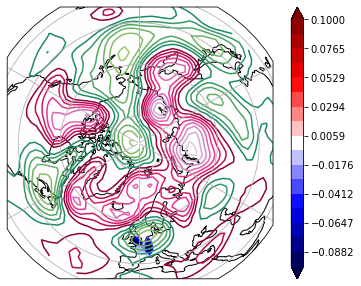

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeat
data_proj = ccrs.PlateCarree()
import cartopy_plots as cplt

t2mlevels = np.linspace(-8.5, 8.5, 18)  # Levels to be used when plotting
zg500levels = np.concatenate((np.arange(-20 * 10, 0, 20), np.arange(20, 10 * 21, 20)))
mrsolevels = np.linspace(-.1, .1, 18)

fig2 = plt.figure(figsize=(30, 5))
i = 0
spec2 = gridspec.GridSpec(ncols=4, nrows=1, figure=fig2)
m = fig2.add_subplot(spec2[0,i], projection=ccrs.Orthographic(central_latitude=90))
#ax.append(m)
m.set_extent([-180,180, 30, 90], crs=data_proj)
cplt.geo_contourf(m, LON, LAT, X[12,:,:,2], levels=mrsolevels, cmap="seismic", title=None, put_colorbar=True, draw_coastlines=True, draw_gridlines=True, draw_labels=False, greenwich=True)
cplt.geo_contour(m, LON, LAT, X[12,:,:,1], levels=zg500levels, cmap1='PuRd', cmap2='summer', greenwich=True)

Now we can do analysis of some of the runs I have performed. They are all located in gmiloshe/
Below we will plot average score as a function of epoch. Here I am not using collective=True so the average score per epoch will be reported as a result. So in principle one could achieve better metrics

Text(0.5, 1.0, '100 yrs, zg500')

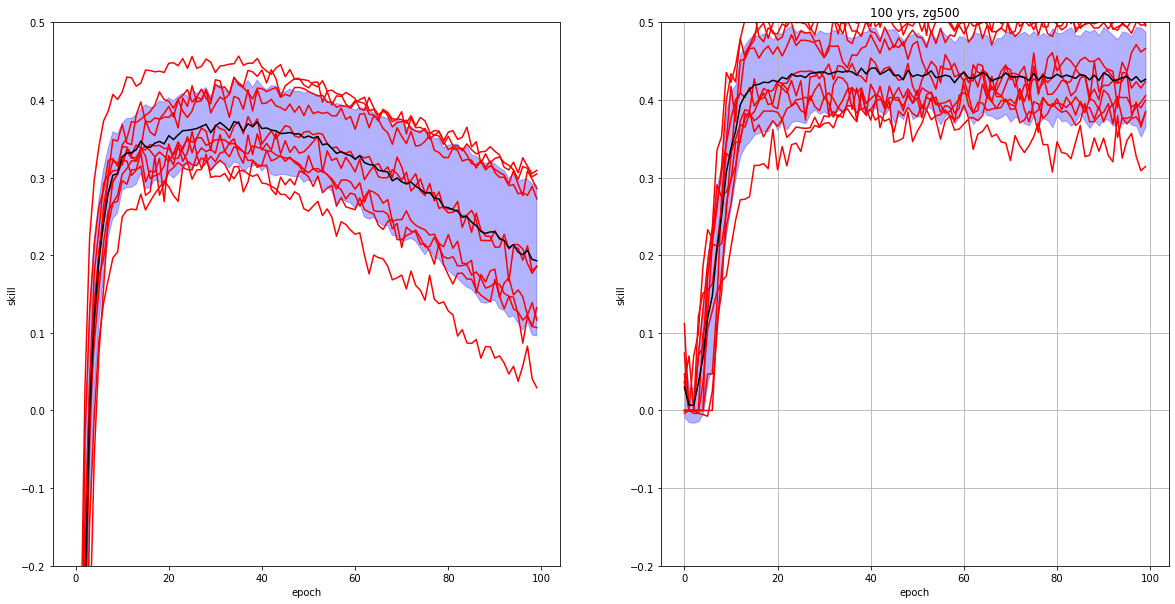

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
percent = 5
df = []
tau = 0
for i in range(10):
    df.append(pd.read_csv(f'models/u1yrs500/0/fold_{i}/history.csv')) #df.append(pd.read_csv(f'models/u1yrs100/0/fold_{i}/history.csv'))
df_concat = pd.concat(df, keys=range(10),names=['fold', None])
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
df_concat['val_CustomSkill'] = (maxskill - df_concat['val_CustomLoss'])/maxskill
fig = plt.figure(figsize=(20, 10))
spec= gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax = []
for i, label in enumerate(['val_CustomSkill', 'val_MCC']):
    ax.append(fig.add_subplot(spec[0,i]))
    dfmean = df_concat.groupby(level=1).mean().loc[:,label]
    dfstd = df_concat.groupby(level=1).std().loc[:,label]
    plt.fill_between(range(len(dfmean)), dfmean.values - dfstd.values, dfmean.values+ dfstd.values, color='blue',alpha=0.3)
    for i in range(10):
        plt.plot((df_concat.loc[i].loc[:,label]),color='red')
    plt.plot(dfmean, color='black')
    plt.ylim(-0.2,0.5)
    plt.xlabel('epoch')
    plt.ylabel('skill')
plt.grid(True)
plt.title('100 yrs, zg500')

It looks like we have enough epochs to claim we converged to optimal parameters. Let's put everyting together

In [3]:
import os
import Learn2_new as ln
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
percent=5
ut = ln.ut
folder = 'models/u1yrs500/'
runs = ut.json2dict(f"{folder}/runs.json")
config = ut.json2dict(f"{folder}/config.json")
dg = []
taus = []
for key, value in runs.items():
    if value['args'] != {}:
        tau = value['args']['tau']
    else:
        tau = ut.extract_nested(config, 'tau')
    taus.append(tau)
    data= pd.read_csv(f"{folder}/{value['name']}/fold_{0}/history.csv")
    #print(tau)
    df = []
    for i in range(10):
        df.append(pd.read_csv(f"{folder}/{value['name']}/fold_{i}/history.csv"))
    #print(f'{len(df) = }')
    dg.append(pd.concat(df, keys=range(10),names=['fold', None]))
dg_frame = pd.concat(dg, keys=taus,names=['tau','fold', None])
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
dg_frame['val_CustomSkill'] = (maxskill - dg_frame['val_CustomLoss'])/maxskill
dg_fold_mean = dg_frame.groupby(['tau','epoch']).mean()  # We need to compute fold-wise mean
dg_idxmax = dg_fold_mean.loc[:,'val_CustomSkill'].groupby(['tau']).idxmax() # Now we compute the indices for which the val_CustomSkill is maximal because we need to apply them to standard deviation as well
dg_foldmean_maxskill_mean = dg_frame.groupby(['tau','epoch']).mean().loc[dg_idxmax] #Now we are in a position to also compute standard deviation and mean for those columns which correspond to the optimal customskill
dg_foldmean_maxskill_std = dg_frame.groupby(['tau','epoch']).std().loc[dg_idxmax]
plt.errorbar(-dg_foldmean_maxskill_std['val_CustomSkill'].droplevel(level=1).index,dg_foldmean_maxskill_mean['val_CustomSkill'].values,dg_foldmean_maxskill_std['val_CustomSkill'].values, label='u1yrs500')
plt.xlabel('tau')
plt.ylabel('val_CustomSkill')
plt.legend(loc='best')

KeyError: 'tau'

In [4]:
folder = 'models/u10yrs500'
runs = ut.json2dict(f"{folder}/runs.json")
config = ut.json2dict(f"{folder}/config.json")
for key, value in runs.items():
    print(value['name'])
runs_grouped = ln.group_by_varying({k: r['args'] for k,r in runs.items()}, variable='tau', config_dict_flat={'tau': 0})

0
1--tau__-5
2--tau__-10
3--tau__-15
4--tau__20
5--tau__-25
6--tau__-30
7--fields__(zg500,mrso_filtered)
8--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-5
9--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-10
10--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-15
11--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-20
12--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-25
13--fields__(zg500,mrso_filtered,t2m_ghost)--tau__-30


In [5]:
runs_grouped[0]

{'args': {},
 'runs': ['0', '1', '2', '3', '4', '5', '6'],
 'tau': [0, -5, -10, -15, 20, -25, -30]}

In [6]:
runs_grouped[0]['tau'], runs_grouped[0]['runs']

([0, -5, -10, -15, 20, -25, -30], ['0', '1', '2', '3', '4', '5', '6'])

In [7]:
runs['2']['name']

'2--tau__-10'

taus = [0, -5, -10, -15, 20, -25, -30]
0
len(df) = 10
1--tau__-5
len(df) = 10
2--tau__-10
len(df) = 10
3--tau__-15
len(df) = 10
4--tau__20
len(df) = 10
5--tau__-25
len(df) = 10
6--tau__-30
len(df) = 10


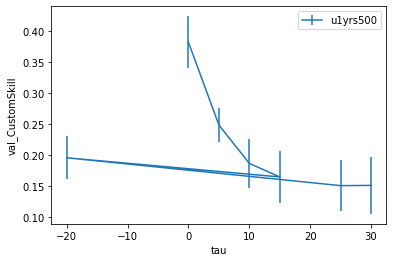

In [8]:

folder = 'models/u10yrs500'
runs = ut.json2dict(f"{folder}/runs.json")
config = ut.json2dict(f"{folder}/config.json")
#for key, value in runs.items():
#    print(value['name'])
runs_grouped = ln.group_by_varying({k: r['args'] for k,r in runs.items()}, variable='tau', config_dict_flat={'tau': 0})

dg = []
taus = runs_grouped[0]['tau']
print(f"{taus = }")

for each_run in runs_grouped[0]['runs']:
    print(runs[each_run]['name'])
    df = []
    for i in range(10):
        df.append(pd.read_csv(f"{folder}/{runs[each_run]['name']}/fold_{i}/history.csv"))
    print(f'{len(df) = }')
    dg.append(pd.concat(df, keys=range(len(df)),names=['fold', None]))

dg_frame = pd.concat(dg, keys=taus,names=['tau','fold', None])
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
dg_frame['val_CustomSkill'] = (maxskill - dg_frame['val_CustomLoss'])/maxskill
dg_fold_mean = dg_frame.groupby(['tau','epoch']).mean()  # We need to compute fold-wise mean
dg_idxmax = dg_fold_mean.loc[:,'val_CustomSkill'].groupby(['tau']).idxmax() # Now we compute the indices for which the val_CustomSkill is maximal because we need to apply them to standard deviation as well
dg_foldmean_maxskill_mean = dg_frame.groupby(['tau','epoch']).mean().loc[dg_idxmax] #Now we are in a position to also compute standard deviation and mean for those columns which correspond to the optimal customskill
dg_foldmean_maxskill_std = dg_frame.groupby(['tau','epoch']).std().loc[dg_idxmax]
plt.errorbar(-dg_foldmean_maxskill_std['val_CustomSkill'].droplevel(level=1).index,dg_foldmean_maxskill_mean['val_CustomSkill'].values,dg_foldmean_maxskill_std['val_CustomSkill'].values, label='u1yrs500')
plt.xlabel('tau')
plt.ylabel('val_CustomSkill')
plt.legend(loc='best')

Text(0.5, 1.0, '500 yrs, zg500')

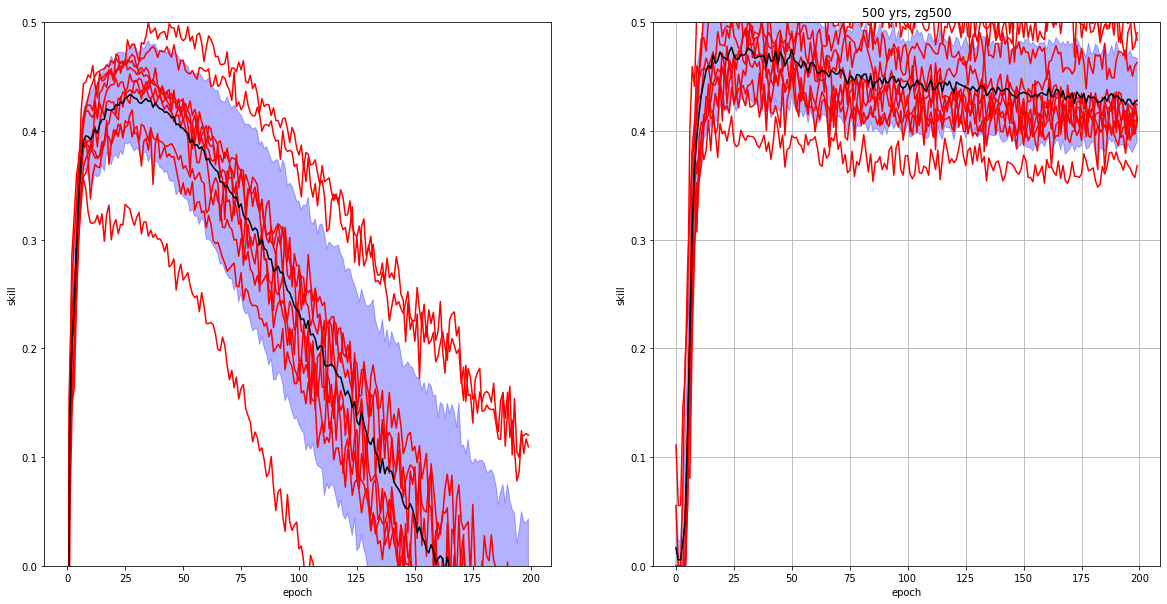

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
percent = 5
df = []
tau = 0
for i in range(10):
    df.append(pd.read_csv(f'models/u1yrs800/4--fields__(t2m_filtered,zg500,mrso_filtered)/fold_{i}/history.csv')) #df.append(pd.read_csv(f'models/u1yrs100/0/fold_{i}/history.csv'))
df_concat = pd.concat(df, keys=range(10),names=['fold', None])
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
df_concat['val_CustomSkill'] = (maxskill - df_concat['val_CustomLoss'])/maxskill
fig = plt.figure(figsize=(20, 10))
spec= gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax = []
for i, label in enumerate(['val_CustomSkill', 'val_MCC']):
    ax.append(fig.add_subplot(spec[0,i]))
    dfmean = df_concat.groupby(level=1).mean().loc[:,label]
    dfstd = df_concat.groupby(level=1).std().loc[:,label]
    plt.fill_between(range(len(dfmean)), dfmean.values - dfstd.values, dfmean.values+ dfstd.values, color='blue',alpha=0.3)
    for i in range(10):
        plt.plot((df_concat.loc[i].loc[:,label]),color='red')
    plt.plot(dfmean, color='black')
    plt.ylim(0,0.5)
    plt.xlabel('epoch')
    plt.ylabel('skill')
plt.grid(True)
plt.title('500 yrs, zg500')

Text(0.5, 1.0, '500 yrs, zg500')

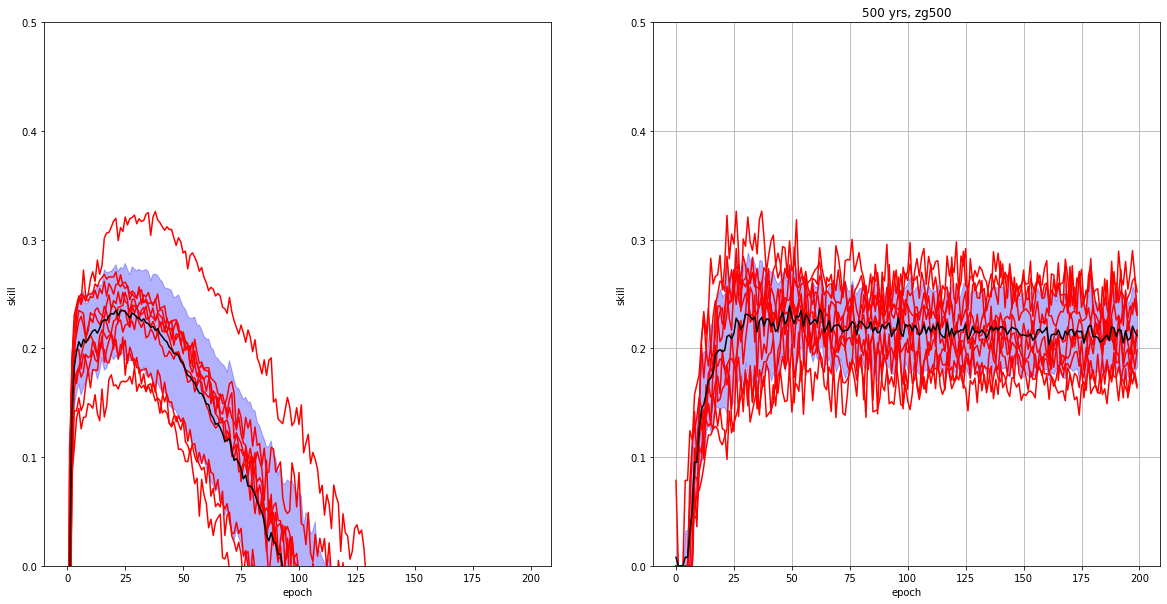

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
percent = 5
df = []
tau = 0
for i in range(10):
    df.append(pd.read_csv(f'models/u1yrs800/6--fields__(zg500)/fold_{i}/history.csv')) #df.append(pd.read_csv(f'models/u1yrs100/0/fold_{i}/history.csv'))
df_concat = pd.concat(df, keys=range(10),names=['fold', None])
maxskill = -(percent/100.)*np.log(percent/100.)-(1-percent/100.)*np.log(1-percent/100.)
df_concat['val_CustomSkill'] = (maxskill - df_concat['val_CustomLoss'])/maxskill
fig = plt.figure(figsize=(20, 10))
spec= gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax = []
for i, label in enumerate(['val_CustomSkill', 'val_MCC']):
    ax.append(fig.add_subplot(spec[0,i]))
    dfmean = df_concat.groupby(level=1).mean().loc[:,label]
    dfstd = df_concat.groupby(level=1).std().loc[:,label]
    plt.fill_between(range(len(dfmean)), dfmean.values - dfstd.values, dfmean.values+ dfstd.values, color='blue',alpha=0.3)
    for i in range(10):
        plt.plot((df_concat.loc[i].loc[:,label]),color='red')
    plt.plot(dfmean, color='black')
    plt.ylim(0,0.5)
    plt.xlabel('epoch')
    plt.ylabel('skill')
plt.grid(True)
plt.title('500 yrs, zg500')